## 1. Setup and Data Loading

In [1]:
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load graph edges
with open('data/github_stargazers/git_edges.json', 'r') as f:
    edges_dict = json.load(f)

# Load targets
targets_df = pd.read_csv('data/github_stargazers/git_target.csv')

print(f"Number of graphs: {len(edges_dict)}")
print(f"Number of labeled graphs: {len(targets_df)}")
print(f"\nTarget distribution:")
print(targets_df['target'].value_counts())

Number of graphs: 12725
Number of labeled graphs: 12725

Target distribution:
target
1    6808
0    5917
Name: count, dtype: int64


## 2. Basic Graph Statistics and Structure

- **Connectivity**: Whether all nodes are reachable from any node
- **Density**: $\frac{2|E|}{|V|(|V|-1)}$ for undirected graphs (ratio of actual to possible edges)

**Graph Representations:**

- **Adjacency Matrix**: $n \times n$ matrix where $A[i,j] = 1$ if edge $(i,j)$ exists
- **Adjacency List**: Dictionary mapping each node to its neighbors (used by NetworkX)
- **Incidence Matrix**: $n \times m$ matrix showing node-edge relationships

In [3]:
# Convert edges to NetworkX graphs
def create_graph(edge_list):
    """Create undirected graph from edge list"""
    G = nx.Graph()
    G.add_edges_from(edge_list)
    return G

# Create all graphs
graphs = {graph_id: create_graph(edges) for graph_id, edges in edges_dict.items()}
print(f"Created {len(graphs)} graphs")

Created 12725 graphs


In [7]:
# Compute basic statistics
stats = []
for graph_id, G in list(graphs.items())[:100]:
    stats.append({
        'graph_id': graph_id,
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'density': nx.density(G),
        'is_connected': nx.is_connected(G)
    })

stats_df = pd.DataFrame(stats)
print(stats_df.describe())
stats_df

        num_nodes    num_edges     density
count  100.000000   100.000000  100.000000
mean   113.710000   228.490000    0.076492
std    148.981817   344.235516    0.059603
min     10.000000    10.000000    0.005846
25%     26.750000    31.750000    0.025980
50%     51.500000    77.000000    0.065810
75%    125.000000   228.500000    0.104840
max    815.000000  1969.000000    0.345455


,graph_id,num_nodes,num_edges,density,is_connected
0,0,71,78,0.031388,True
1,1,137,203,0.021790,True
2,2,128,440,0.054134,True
3,3,99,173,0.035663,True
4,4,77,207,0.070745,True
...,...,...,...,...,...
95,95,167,325,0.023447,True
96,96,242,340,0.011659,True
97,97,79,155,0.050308,True
98,98,30,41,0.094253,True


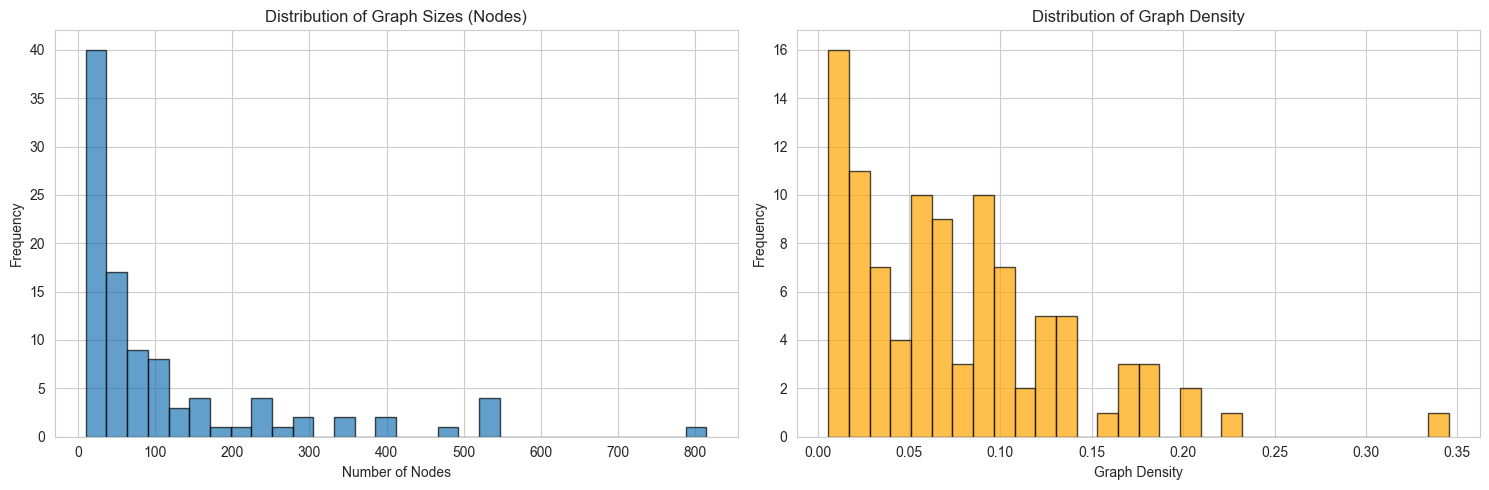

In [8]:
# Visualize graph size distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(stats_df['num_nodes'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Nodes')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Graph Sizes (Nodes)')

axes[1].hist(stats_df['density'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Graph Density')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Graph Density')

plt.tight_layout()
plt.show()

## 3. Centrality Measures Analysis

**Centrality measures** quantify the importance or influence of nodes in a network. Different measures capture different aspects of importance:

- **Clustering Coefficient**: Fraction of neighbors that are connected (local cohesion)
- **Degree Centrality**: Number of connections (local importance)
- **Closeness**: Average distance to all other nodes (efficiency)
- **Eigenvector Centrality**: Connected to important nodes (recursive importance)
- **Betweenness**: Frequency on shortest paths (bridge/broker role)
- **PageRank**: Web page ranking considering link structure

In [9]:
# Select a sample graph for detailed analysis
sample_graph_id = list(graphs.keys())[10]
G_sample = graphs[sample_graph_id]
print(f"Analyzing graph {sample_graph_id}")
print(f"Nodes: {G_sample.number_of_nodes()}, Edges: {G_sample.number_of_edges()}")

Analyzing graph 10
Nodes: 61, Edges: 105


### 3.1 Degree Centrality

- Simple but effective for identifying influential nodes

**Definition**: $C_D(v) = \frac{deg(v)}{n-1}$ (normalized by maximum possible degree)

**Interpretation**: 
- High degree = hub or popular node
- Measures immediate connectivity


In [10]:
# Degree Centrality
degree_cent = nx.degree_centrality(G_sample)
print("Top 5 nodes by Degree Centrality:")
for node, cent in sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"Node {node}: {cent:.4f}")

Top 5 nodes by Degree Centrality:
Node 26: 0.4833
Node 41: 0.2833
Node 48: 0.2667
Node 28: 0.1333
Node 57: 0.1167


### 3.2 Eigenvector Centrality

**Definition**: $x_v = \frac{1}{\lambda} \sum_{u \in N(v)} x_u$ where $\lambda$ is the largest eigenvalue

**Key Idea**: A node is important if it's connected to other important nodes

**Properties**:
- Recursively defined: your centrality depends on neighbors' centrality
- Solution to eigenvector equation: $Ax = \lambda x$
- "It's not what you know, but who you know"

**Interpretation**:
- High eigenvector centrality = well-connected to influential nodes
- Used in social network analysis to find influential people

In [11]:
# Eigenvector Centrality
try:
    eigenvector_cent = nx.eigenvector_centrality(G_sample, max_iter=1000)
    print("\nTop 5 nodes by Eigenvector Centrality:")
    for node, cent in sorted(eigenvector_cent.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"Node {node}: {cent:.4f}")
except:
    print("Eigenvector centrality computation failed (graph may not be connected)")
    eigenvector_cent = None


Top 5 nodes by Eigenvector Centrality:
Node 26: 0.5029
Node 41: 0.3742
Node 48: 0.3058
Node 23: 0.2148
Node 35: 0.1735


### 3.3 PageRank Centrality

- Stationary distribution of a random walk with restarts

**Definition**: $PR(v) = \frac{1-d}{n} + d \sum_{u \in N^{-}(v)} \frac{PR(u)}{deg^{+}(u)}$

- Solves the "rank sink" problem of eigenvector centrality
- $(1-d)$: probability of random jump (teleportation)

**Key Features**:

- **Damping factor** $d$ (typically 0.85): probability of following a link
- Developed by Google for web page ranking

In [12]:
# PageRank Centrality
pagerank_cent = nx.pagerank(G_sample, alpha=0.85)
print("\nTop 5 nodes by PageRank:")
for node, cent in sorted(pagerank_cent.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"Node {node}: {cent:.4f}")


Top 5 nodes by PageRank:
Node 26: 0.1274
Node 48: 0.0699
Node 41: 0.0686
Node 28: 0.0353
Node 57: 0.0315


### 3.4 Betweenness Centrality

- Important for information flow and network disruption

**Definition**: $C_B(v) = \sum_{s \neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}$

Where $\sigma_{st}$ is the number of shortest paths from $s$ to $t$, and $\sigma_{st}(v)$ is the number passing through $v$.

**Interpretation**:

- High betweenness = **bridge** or **gatekeeper** between communities
- Measures how often a node lies on shortest paths


In [13]:
# Betweenness Centrality
betweenness_cent = nx.betweenness_centrality(G_sample)
print("\nTop 5 nodes by Betweenness Centrality:")
for node, cent in sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"Node {node}: {cent:.4f}")


Top 5 nodes by Betweenness Centrality:
Node 26: 0.6612
Node 48: 0.2677
Node 41: 0.1993
Node 28: 0.0962
Node 57: 0.0803


### 3.5 Closeness Centrality

- Only defined for connected graphs (or largest component)

**Definition**: $C_C(v) = \frac{n-1}{\sum_{u \neq v} d(v,u)}$

Where $d(v,u)$ is the shortest path distance from $v$ to $u$.- Measures how quickly information can spread from a node

**Interpretation**:

- Node can efficiently communicate with all others
- High closeness = central position in network

In [14]:
# Closeness Centrality
if nx.is_connected(G_sample):
    closeness_cent = nx.closeness_centrality(G_sample)
    print("\nTop 5 nodes by Closeness Centrality:")
    for node, cent in sorted(closeness_cent.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"Node {node}: {cent:.4f}")
else:
    print("Graph is not connected, computing closeness on largest component")
    largest_cc = max(nx.connected_components(G_sample), key=len)
    G_cc = G_sample.subgraph(largest_cc).copy()
    closeness_cent = nx.closeness_centrality(G_cc)
    print(f"\nTop 5 nodes by Closeness Centrality (largest component with {len(largest_cc)} nodes):")
    for node, cent in sorted(closeness_cent.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"Node {node}: {cent:.4f}")


Top 5 nodes by Closeness Centrality:
Node 26: 0.6383
Node 41: 0.5310
Node 48: 0.5128
Node 23: 0.4615
Node 14: 0.4580


### 3.6 Clustering Coefficient

**Definition**: $C(v) = \frac{2e_v}{k_v(k_v-1)}$ 

where $e_v$ is edges among neighbors and $k_v$ is degree

**Key Idea**: Fraction of your neighbors that are also neighbors of each other

**Properties**:
- Measures **local cohesion** and **transitivity**
- High clustering = friends of friends are also friends (triangle formation)
- Range: [0, 1] where 1 means all neighbors are connected

**Interpretation**:
- High clustering coefficient = tight-knit community around the node
- Low clustering coefficient = node bridges different groups

In [16]:
# Clustering Coefficient
clustering_coef = nx.clustering(G_sample)
avg_clustering = nx.average_clustering(G_sample)

print(f"\nAverage Clustering Coefficient: {avg_clustering:.4f}")
print("\nTop 5 nodes by Clustering Coefficient:")
for node, coef in sorted(clustering_coef.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"Node {node}: {coef:.4f}")


Average Clustering Coefficient: 0.3457

Top 5 nodes by Clustering Coefficient:
Node 1: 1.0000
Node 2: 1.0000
Node 4: 1.0000
Node 5: 1.0000
Node 7: 1.0000
Node 49: 1.0000
Node 14: 1.0000
Node 15: 1.0000
Node 17: 1.0000
Node 33: 1.0000


### 3.7 Compare Centrality Measures

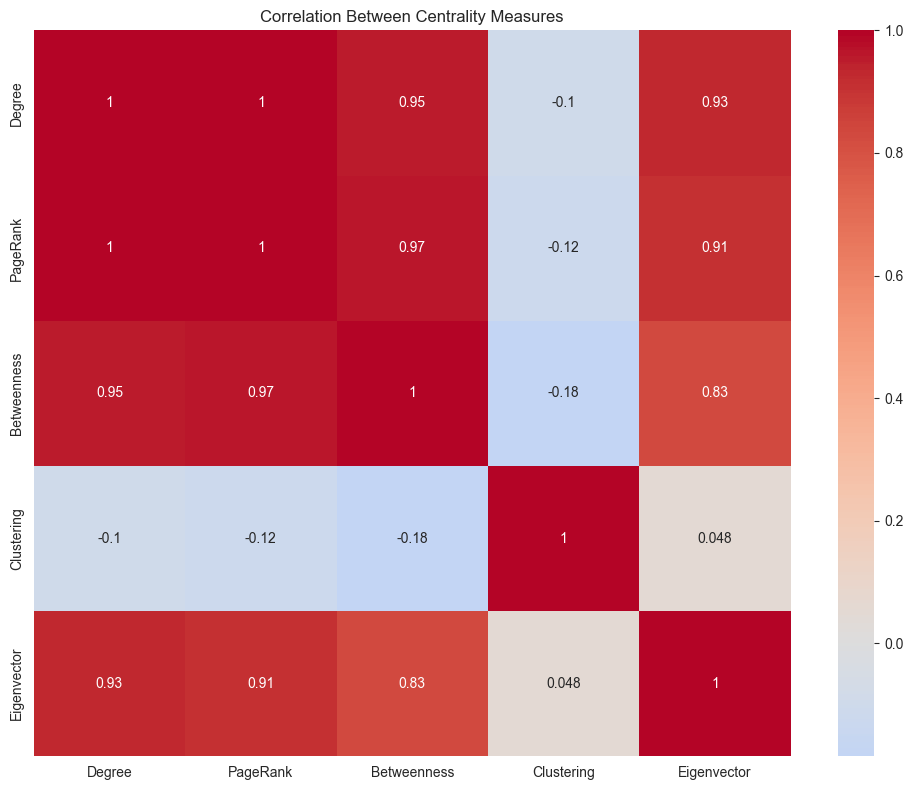

In [17]:
# Create dataframe with all centrality measures
centrality_df = pd.DataFrame({
    'Degree': degree_cent,
    'PageRank': pagerank_cent,
    'Betweenness': betweenness_cent,
    'Clustering': clustering_coef
})

if eigenvector_cent:
    centrality_df['Eigenvector'] = pd.Series(eigenvector_cent)

# Correlation between centrality measures
plt.figure(figsize=(10, 8))
sns.heatmap(centrality_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Centrality Measures')
plt.tight_layout()
plt.show()

## 4. Community Detection

**Community Detection** aims to partition networks into densely connected groups (communities/clusters).

**Key Concepts**:
- **Community**: Subset of nodes with more internal connections than external
- **Quality Metrics**:
  - **Modularity**: Difference between actual and expected edges in communities
  - **Conductance**: Ratio of cut edges to total edges (lower is better)
  - **Internal Density**: Edge density within each community
  - **Coverage**: Fraction of edges within communities

**Approaches**:
1. **Hierarchical**: Build dendrograms (e.g., Girvan-Newman)
2. **Optimization**: Maximize quality functions (e.g., Louvain)
3. **Structural**: Based on graph properties (e.g., K-core, K-clique)

### 4.1 K-Core Decomposition

**Definition**: A $k$-core is a maximal subgraph where every node has degree $\geq k$ within that subgraph

**Core Number**: $c(v)$ is the largest $k$ such that node $v$ belongs to a $k$-core

**Algorithm**:
1. Remove all nodes with degree < $k$
2. Update degrees of remaining nodes
3. Repeat until all remaining nodes have degree $\geq k$

**Properties**:
- Nested structure: $(k+1)$-core is subset of $k$-core
- Fast: $O(m)$ time complexity
- Identifies hierarchical structure of network cohesion

**Applications**:
- Find most cohesive subgraphs
- Identify core vs periphery in social networks
- Network visualization (high k-core = inner circle)

In [19]:
# K-Core decomposition
core_numbers = nx.core_number(G_sample)
max_core = max(core_numbers.values())
print(f"Maximum k-core: {max_core}")

# Get the k-core for different values of k
core_distribution = Counter(core_numbers.values())
print("\nCore number distribution:")
for k in sorted(core_distribution.keys()):
    print(f"  {k}-core: {core_distribution[k]} nodes")

Maximum k-core: 3

Core number distribution:
  1-core: 20 nodes
  2-core: 26 nodes
  3-core: 15 nodes


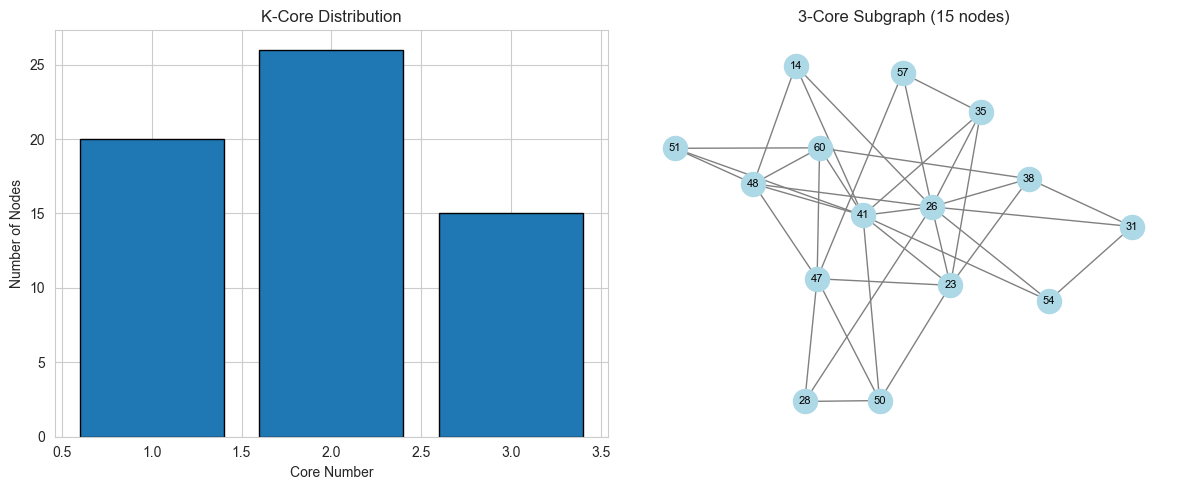

In [20]:
# Visualize core structure
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(core_distribution.keys(), core_distribution.values(), edgecolor='black')
plt.xlabel('Core Number')
plt.ylabel('Number of Nodes')
plt.title('K-Core Distribution')

plt.subplot(1, 2, 2)
# Extract maximum k-core
k_core = nx.k_core(G_sample, k=max_core)
pos = nx.spring_layout(k_core, seed=42)
nx.draw(k_core, pos, node_color='lightblue', node_size=300, 
        with_labels=True, font_size=8, edge_color='gray')
plt.title(f'{max_core}-Core Subgraph ({k_core.number_of_nodes()} nodes)')

plt.tight_layout()
plt.show()

### 4.2 K-Clique Communities

**Clique**: A complete subgraph where every node is connected to every other node

**Maximal Clique**: A clique that cannot be extended by adding more nodes

**K-Clique Community**: Union of all $k$-cliques that can be reached through adjacent $k$-cliques
- Two $k$-cliques are adjacent if they share $k-1$ nodes

**Properties**:
- Cliques represent strongest form of cohesion (everyone knows everyone)
- Finding largest clique is NP-complete
- K-clique communities allow overlapping (nodes can belong to multiple communities)

**Applications**:
- Social circles in networks
- Protein interaction modules
- Collaboration networks

Number of maximal cliques: 64
Largest clique size: 4
Average clique size: 2.48


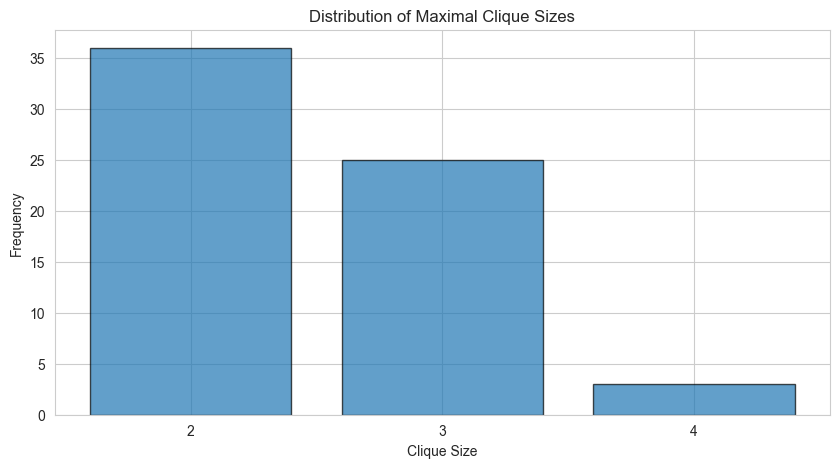

In [21]:
# Find all maximal cliques
cliques = list(nx.find_cliques(G_sample))
clique_sizes = [len(c) for c in cliques]

print(f"Number of maximal cliques: {len(cliques)}")
print(f"Largest clique size: {max(clique_sizes)}")
print(f"Average clique size: {np.mean(clique_sizes):.2f}")

# Clique size distribution
clique_dist = Counter(clique_sizes)
plt.figure(figsize=(10, 5))
plt.bar(clique_dist.keys(), clique_dist.values(), edgecolor='black', alpha=0.7)
plt.xlabel('Clique Size')
plt.ylabel('Frequency')
plt.title('Distribution of Maximal Clique Sizes')
plt.xticks(range(min(clique_sizes), max(clique_sizes)+1))
plt.show()

In [22]:
# K-clique communities (k=3)
try:
    k = 3
    k_clique_communities = list(nx.community.k_clique_communities(G_sample, k))
    print(f"\nNumber of {k}-clique communities: {len(k_clique_communities)}")
    
    # Show sizes of communities
    comm_sizes = [len(comm) for comm in k_clique_communities]
    print(f"Community sizes: {sorted(comm_sizes, reverse=True)}")
except:
    print(f"Could not find {k}-clique communities (graph may be too sparse)")


Number of 3-clique communities: 5
Community sizes: [24, 5, 4, 3, 3]


### 4.3 Louvain Algorithm (Modularity-based)

**Modularity**: $Q = \frac{1}{2m} \sum_{ij} \left[A_{ij} - \frac{k_i k_j}{2m}\right] \delta(c_i, c_j)$

Where:
- $m$ = number of edges
- $A_{ij}$ = adjacency matrix
- $k_i$ = degree of node $i$
- $\delta(c_i, c_j) = 1$ if nodes are in same community

**Louvain Algorithm** (Greedy, Hierarchical):
1. **Phase 1**: Each node starts in own community
   - Iteratively move nodes to maximize modularity gain
2. **Phase 2**: Build new network where nodes = communities
3. Repeat until no improvement

**Properties**:
- Fast: $O(n \log n)$ in practice
- High modularity scores
- Hierarchical community structure
- Non-deterministic (depends on node order)

In [23]:
# Louvain community detection
from networkx.algorithms import community as nx_comm

louvain_communities = nx_comm.greedy_modularity_communities(G_sample)
louvain_modularity = nx_comm.modularity(G_sample, louvain_communities)

print(f"Louvain Algorithm:")
print(f"  Number of communities: {len(louvain_communities)}")
print(f"  Modularity: {louvain_modularity:.4f}")
print(f"  Community sizes: {sorted([len(c) for c in louvain_communities], reverse=True)}")

Louvain Algorithm:
  Number of communities: 6
  Modularity: 0.4384
  Community sizes: [18, 12, 11, 9, 8, 3]


### 4.4 Girvan-Newman Algorithm

**Key Idea**: Edges connecting communities have high **edge betweenness**

**Algorithm**:
1. Calculate betweenness for all edges
2. Remove edge with highest betweenness
3. Recalculate betweenness
4. Repeat until desired number of communities

**Advantage**: 
- Intuitive and interpretable
- Produces hierarchy of communities

**Disadvantage**:
- Computationally expensive
- Need to choose when to stop splitting

**Complexity**: $O(m^2 n)$ - slow for large graphs

**Produces**: Hierarchical dendrogram of community structure

In [24]:
# Girvan-Newman (edge betweenness)
if G_sample.number_of_nodes() < 100:  # Only run on smaller graphs: can be slow for large graphs
    from networkx.algorithms.community import girvan_newman
    
    # Get first level of Girvan-Newman
    comp = girvan_newman(G_sample)
    gn_communities = tuple(sorted(c) for c in next(comp))
    gn_modularity = nx_comm.modularity(G_sample, gn_communities)
    
    print(f"\nGirvan-Newman Algorithm (1 split):")
    print(f"  Number of communities: {len(gn_communities)}")
    print(f"  Modularity: {gn_modularity:.4f}")
    print(f"  Community sizes: {[len(c) for c in gn_communities]}")
else:
    print("\nGirvan-Newman skipped (graph too large)")


Girvan-Newman Algorithm (1 split):
  Number of communities: 2
  Modularity: 0.0370
  Community sizes: [3, 58]


### 4.5 Community Quality Metrics

In [30]:
# Compute community quality metrics for Louvain communities
def compute_community_metrics(G, communities):
    """Compute various community quality metrics"""
    metrics = []
    
    for i, community in enumerate(communities):
        subgraph = G.subgraph(community)
        
        # Internal density
        internal_edges = subgraph.number_of_edges()
        n = len(community)
        max_edges = n * (n - 1) / 2
        internal_density = internal_edges / max_edges if max_edges > 0 else 0
        
        # Cut edges (edges leaving the community)
        cut_edges = 0
        for node in community:
            for neighbor in G.neighbors(node):
                if neighbor not in community:
                    cut_edges += 1
        
        # Conductance
        total_edges = 2 * internal_edges + cut_edges
        conductance = cut_edges / total_edges if total_edges > 0 else 0
        
        metrics.append({
            'community': i,
            'size': n,
            'internal_density': internal_density,
            'cut_edges': cut_edges,
            'conductance': conductance
        })
    
    return pd.DataFrame(metrics)

louvain_metrics = compute_community_metrics(G_sample, louvain_communities)
print("\nLouvain Community Metrics:")
print(louvain_metrics)
print(f"\nAverage Internal Density: {louvain_metrics['internal_density'].mean():.4f}")
print(f"Average Conductance: {louvain_metrics['conductance'].mean():.4f}")


Louvain Community Metrics:
   community  size  internal_density  cut_edges  conductance
0          0    18          0.163399         17     0.253731
1          1    12          0.181818         22     0.478261
2          2    11          0.236364         16     0.380952
3          3     9          0.222222          8     0.333333
4          4     8          0.321429          8     0.307692
5          5     3          0.666667          1     0.200000

Average Internal Density: 0.2986
Average Conductance: 0.3257


### 4.6 Visualize Communities

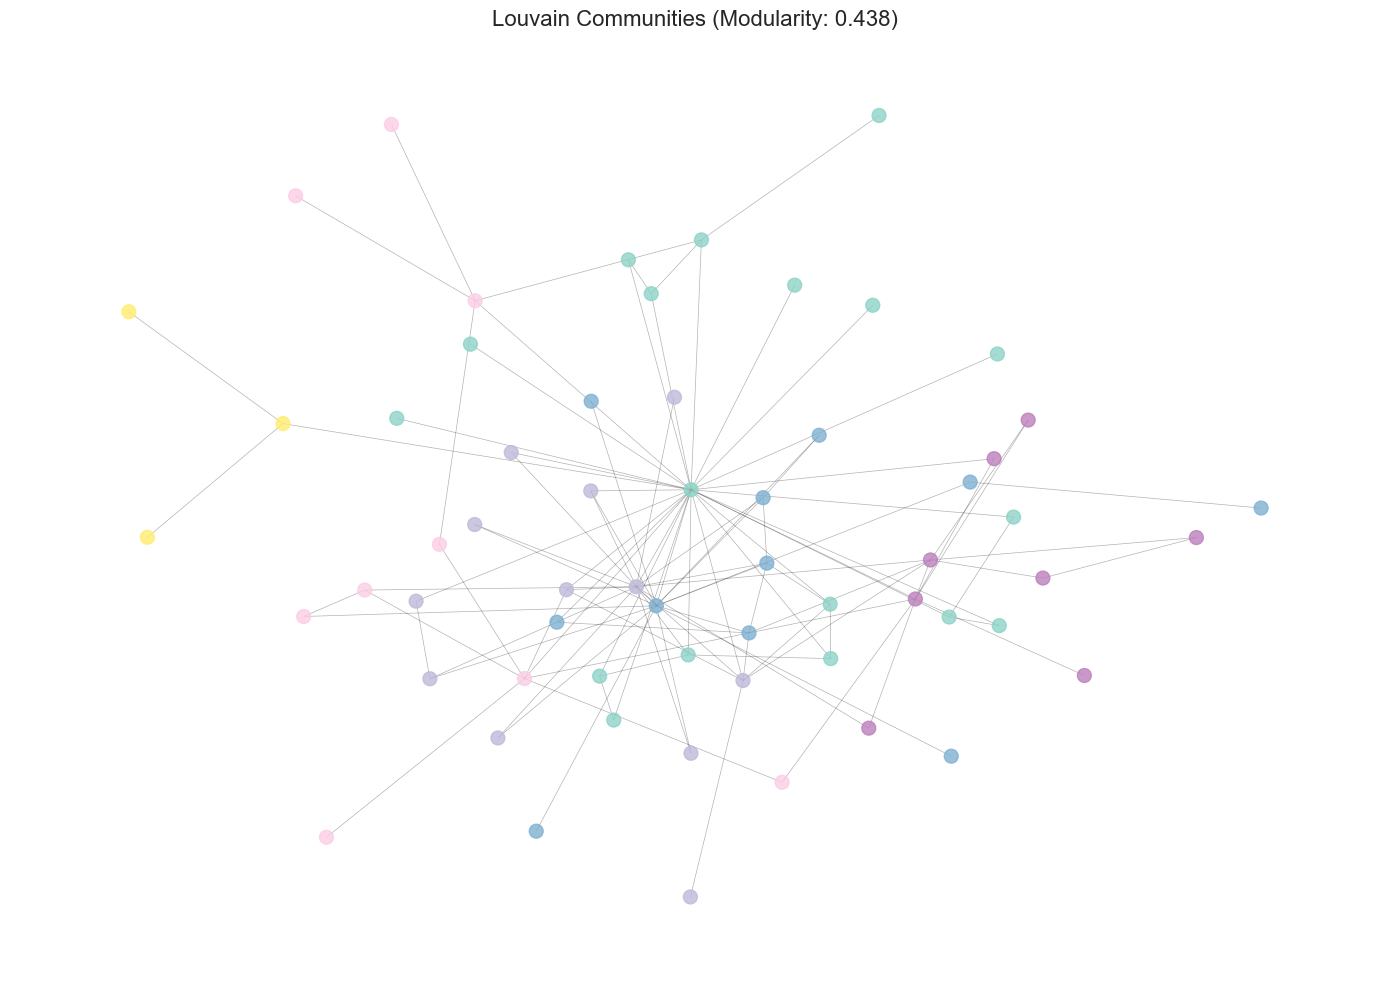

In [31]:
# Visualize communities detected by Louvain
if G_sample.number_of_nodes() < 150:  # Only visualize if not too large
    plt.figure(figsize=(14, 10))
    
    # Create node colors based on community
    node_colors = {}
    colors = plt.cm.Set3(np.linspace(0, 1, len(louvain_communities)))
    
    for idx, community in enumerate(louvain_communities):
        for node in community:
            node_colors[node] = colors[idx]
    
    # Layout
    pos = nx.spring_layout(G_sample, k=0.5, iterations=50, seed=42)
    
    # Draw
    nx.draw_networkx_nodes(G_sample, pos, node_color=[node_colors[n] for n in G_sample.nodes()],
                           node_size=100, alpha=0.8)
    nx.draw_networkx_edges(G_sample, pos, alpha=0.3, width=0.5)
    
    plt.title(f'Louvain Communities (Modularity: {louvain_modularity:.3f})', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Graph too large for visualization")

## 5. Graph-Level Features for Classification

Extract features that can distinguish ML vs Web developer networks.

In [32]:
def extract_graph_features(G):
    """Extract comprehensive graph-level features"""
    features = {}
    
    # Basic properties
    features['num_nodes'] = G.number_of_nodes()
    features['num_edges'] = G.number_of_edges()
    features['density'] = nx.density(G)
    features['is_connected'] = int(nx.is_connected(G))
    
    # Degree statistics
    degrees = [d for n, d in G.degree()]
    features['avg_degree'] = np.mean(degrees)
    features['std_degree'] = np.std(degrees)
    features['max_degree'] = np.max(degrees)
    
    # Clustering
    features['avg_clustering'] = nx.average_clustering(G)
    
    # Centrality statistics
    degree_cent = list(nx.degree_centrality(G).values())
    features['avg_degree_centrality'] = np.mean(degree_cent)
    
    betweenness = list(nx.betweenness_centrality(G).values())
    features['avg_betweenness'] = np.mean(betweenness)
    features['max_betweenness'] = np.max(betweenness)
    
    pagerank = list(nx.pagerank(G).values())
    features['avg_pagerank'] = np.mean(pagerank)
    features['max_pagerank'] = np.max(pagerank)
    
    # Community structure
    try:
        communities = nx_comm.greedy_modularity_communities(G)
        features['num_communities'] = len(communities)
        features['modularity'] = nx_comm.modularity(G, communities)
    except:
        features['num_communities'] = 0
        features['modularity'] = 0
    
    # Core structure
    core_numbers = list(nx.core_number(G).values())
    features['max_core'] = np.max(core_numbers) if core_numbers else 0
    features['avg_core'] = np.mean(core_numbers) if core_numbers else 0
    
    # Diameter (for connected graphs or largest component)
    if nx.is_connected(G):
        features['diameter'] = nx.diameter(G)
        features['avg_shortest_path'] = nx.average_shortest_path_length(G)
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        G_cc = G.subgraph(largest_cc)
        features['diameter'] = nx.diameter(G_cc) if len(largest_cc) > 1 else 0
        features['avg_shortest_path'] = nx.average_shortest_path_length(G_cc) if len(largest_cc) > 1 else 0
    
    return features

In [33]:
# Extract features for a sample of graphs
sample_size = min(500, len(graphs))  # Use first 500 graphs
graph_features_list = []

for idx, (graph_id, G) in enumerate(list(graphs.items())[:sample_size]):
    if idx % 50 == 0:
        print(f"Processing graph {idx+1}/{sample_size}...")
    
    features = extract_graph_features(G)
    features['graph_id'] = graph_id
    graph_features_list.append(features)

features_df = pd.DataFrame(graph_features_list)

# Merge with targets
features_df['id'] = features_df['graph_id'].astype(int)
features_with_target = features_df.merge(targets_df, on='id', how='left')

print(f"\nExtracted features for {len(features_df)} graphs")
print(f"Feature columns: {list(features_df.columns)}")

Processing graph 1/500...
Processing graph 51/500...
Processing graph 101/500...
Processing graph 151/500...
Processing graph 201/500...
Processing graph 251/500...
Processing graph 301/500...
Processing graph 351/500...
Processing graph 401/500...
Processing graph 451/500...

Extracted features for 500 graphs
Feature columns: ['num_nodes', 'num_edges', 'density', 'is_connected', 'avg_degree', 'std_degree', 'max_degree', 'avg_clustering', 'avg_degree_centrality', 'avg_betweenness', 'max_betweenness', 'avg_pagerank', 'max_pagerank', 'num_communities', 'modularity', 'max_core', 'avg_core', 'diameter', 'avg_shortest_path', 'graph_id', 'id']


### 5.1 Feature Analysis by Class

In [35]:
# Compare features between classes
ml_graphs = features_with_target[features_with_target['target'] == 1]
web_graphs = features_with_target[features_with_target['target'] == 0]

print("ML Developer Networks:")
print(ml_graphs[['num_nodes', 'num_edges', 'density', 'avg_clustering', 'modularity']].describe())

print("\nWeb Developer Networks:")
print(web_graphs[['num_nodes', 'num_edges', 'density', 'avg_clustering', 'modularity']].describe())

ML Developer Networks:
        num_nodes    num_edges     density  avg_clustering  modularity
count  263.000000   263.000000  263.000000      263.000000  263.000000
mean   103.714829   231.699620    0.075780        0.214702    0.398539
std    140.430250   421.308047    0.057510        0.122834    0.106363
min     10.000000     9.000000    0.006060        0.000000    0.000000
25%     29.000000    37.000000    0.033886        0.137857    0.339178
50%     50.000000    85.000000    0.068598        0.214110    0.400181
75%    108.000000   210.000000    0.098718        0.294827    0.464532
max    946.000000  3557.000000    0.509091        0.656277    0.669346

Web Developer Networks:
        num_nodes    num_edges     density  avg_clustering  modularity
count  237.000000   237.000000  237.000000      237.000000  237.000000
mean   116.523207   217.308017    0.079838        0.178766    0.393351
std    177.525805   382.521809    0.064481        0.134634    0.139292
min     10.000000     9.00000

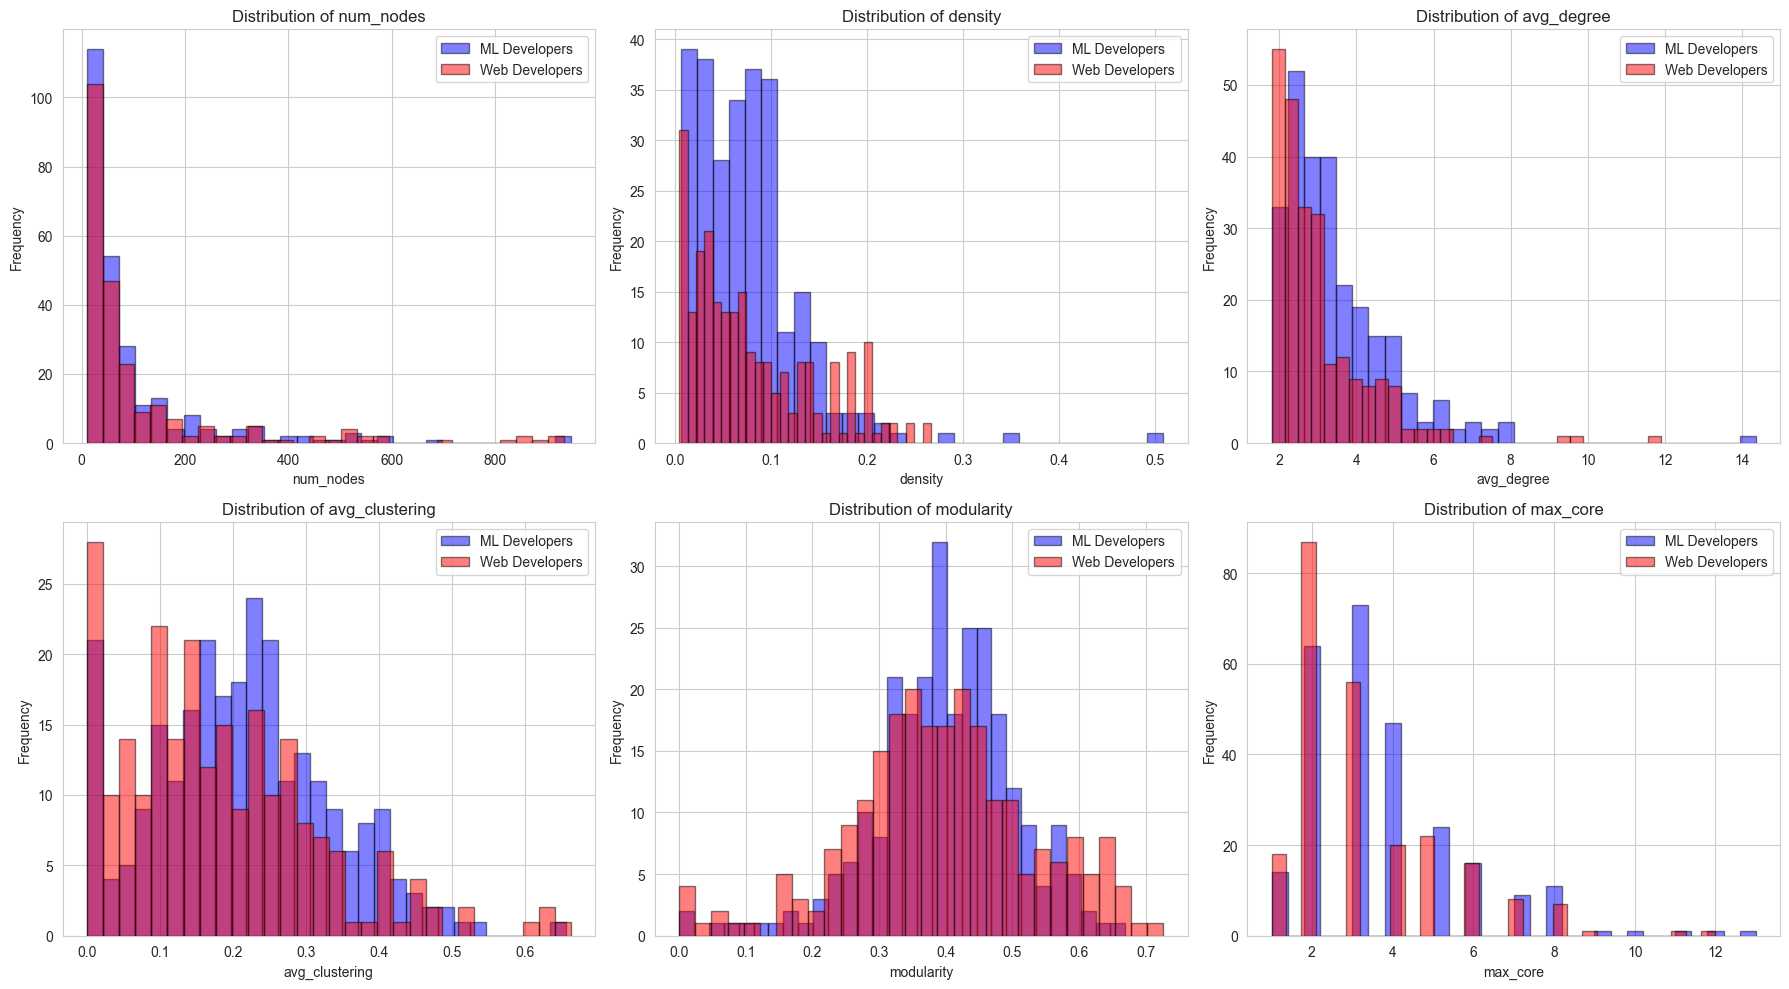

In [36]:
# Visualize feature distributions by class
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

features_to_plot = ['num_nodes', 'density', 'avg_degree', 'avg_clustering', 'modularity', 'max_core']

for idx, feature in enumerate(features_to_plot):
    axes[idx].hist(ml_graphs[feature], bins=30, alpha=0.5, label='ML Developers', color='blue', edgecolor='black')
    axes[idx].hist(web_graphs[feature], bins=30, alpha=0.5, label='Web Developers', color='red', edgecolor='black')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'Distribution of {feature}')
    axes[idx].legend()

plt.tight_layout()
plt.show()